# Arch analysis playground

In [1]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

In [2]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

from postgres_analysis_helpers.circstat_functions import *
from postgres_analysis_helpers.general import *

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions


In [3]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


### Make an empty dataframe and call the retrieval function

In [4]:
base_dataframe = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 

In [5]:
psql = psql_neuroballs(base_dataframe)

71 animals across 5 experimenters found!
Total # of 6982 sessions (unique clusters: 12879)


In [6]:
psql.retrieve_data()

Retrieving data ... (Empty dataframe) ...
247 entries retrieved.


In [7]:
base_dataframe = psql.data()

In [8]:
base_dataframe.animal_id.unique()

array(['72254'], dtype=object)

In [9]:
base_dataframe.columns

Index([u'tetrode_no', u'animal_id', u'n_drive_user', u'session_ts',
       u'cluster_no', u'session_name', u'spiketimes_cluster_bnt',
       u'theta_mean_phase_bnt', u'theta_strength_bnt', u'sparsity_bnt',
       u'tc_stats_peakdirection_bnt', u'borderscore_bnt', u'params_bnt',
       u'gridstats_ellipse_bnt', u'tc_stats_hd_peakrate_bnt', u'mean_rate_bnt',
       u'masked_ratemap_bnt', u'angular_stability_bnt', u'peak_rate_bnt',
       u'selectivity_bnt', u'stability_half_bnt',
       u'tc_stats_mean_direction_bnt', u'bins_angle_center_bnt',
       u'grid_score_bnt', u'gridstats_orientation_bnt', u'numfields_bnt',
       u'calbindin_dist_bnt', u'hist_angle_smooth_bnt', u'informationrate_bnt',
       u'fieldmain_bnt', u'coherence_bnt', u'gridstats_spacing_bnt',
       u'gridstats_ellipse_theta_bnt', u'calbindin_bnt', u'speedscore_bnt',
       u'autocorr_bnt', u'tc_stats_mvl_bnt', u'occupancy_map_bnt',
       u'informationcontent_bnt', u'meanrate_outside_fields_bnt',
       u'phase_stats

In [115]:
inhib_p_thresh = 0.001
latency_thresh = 3
original_len = len(base_dataframe)
base_dataframe = base_dataframe.dropna(subset=['tetrode_no','cluster_no'])
base_dataframe.sort_values('inhib_lowest_p',ascending=True, inplace=True)
base_dataframe.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)
base_dataframe.reset_index(drop=True,inplace=True)
base_dataframe['inhibited'] = (base_dataframe.inhib_lowest_p < inhib_p_thresh) & (base_dataframe.inhibited == True)
print('There are now {} cells in the dataframe (original: {}).'.format(len(base_dataframe),original_len))

There are now 197 cells in the dataframe (original: 207).


### Inhibited cells only

In [116]:
base_dataframe = base_dataframe[base_dataframe.inhibited == True]
print('There are {} inhibited cells in this dataframe.'.format(len(base_dataframe)))

There are 83 inhibited cells in this dataframe.


### Now drop "session_name" and retrieve the base sessions...

In [117]:
base_dataframe.drop('session_name',1,inplace=True)

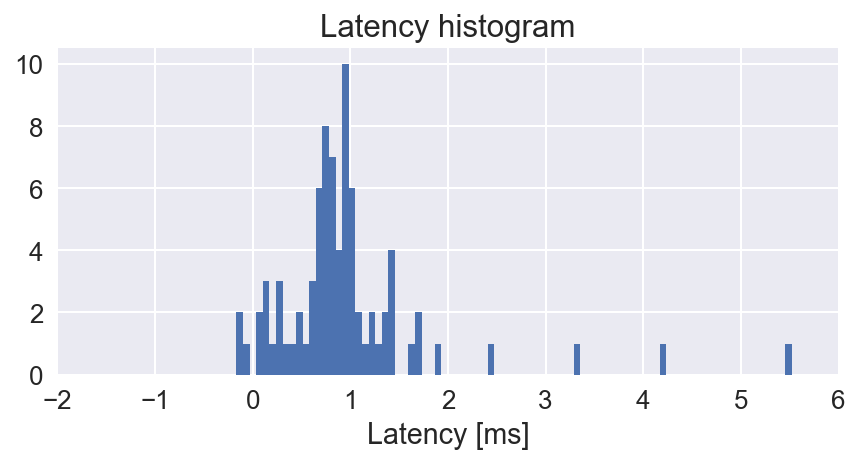

In [118]:
# Draw quick latency histogram:
plt.figure(figsize=(7,3))
plt.hist(base_dataframe.change_point_ms,200)
plt.xlim(-2,6)
plt.title('Latency histogram')
plt.xlabel('Latency [ms]')

In [119]:
psql = psql_neuroballs(base_dataframe)
psql.retrieve_data()

69 animals across 6 experimenters found!
Total # of 8598 sessions (unique clusters: 14315)
Length of input dataframe: 83


Retrieving data ... Dataframe not empty


Success. NaNs: 15



In [120]:
base_dataframe = psql.data()

In [31]:
#base_dataframe_inhib.dropna(subset=['theta_strength','theta_mean_phase','calbindin','gridscore'],inplace=True)

In [132]:
base_dataframe.dropna(subset=['theta_mean_phase_bnt','theta_strength_bnt','grid_score_bnt'],inplace=True)

calbindin = base_dataframe[base_dataframe.calbindin_bnt == 1]
stellate = base_dataframe[base_dataframe.calbindin_bnt == 0]
rest = base_dataframe[pd.isnull(base_dataframe.calbindin_bnt)]
print('Classifier results: {} Calbindin, {} Stellate, {} Unidentified'.format(len(calbindin),len(stellate),len(rest)))

Classifier results: 24 Calbindin, 42 Stellate, 0 Unidentified


In [133]:
#Save the 4 datasets: base_dataframe_inhib, calbindin,stellate,rest

#export_path_pickle  = r"C:\work\python\klusta_analysis\postgres_notebooks\export_dataframes\dave_arch"
#export_path_pickle = "/".join(export_path_pickle.split("\\"))
#base_dataframe_inhib.to_pickle(export_path_pickle + "/all_inhib_arch.pkl")
#calbindin.to_pickle(export_path_pickle + "/calbindin_inhib.pkl")
#stellate.to_pickle(export_path_pickle + "/stellate_inhib.pkl")
#rest.to_pickle(export_path_pickle + "/rest_inhib.pkl")

C:\Users\horsto\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


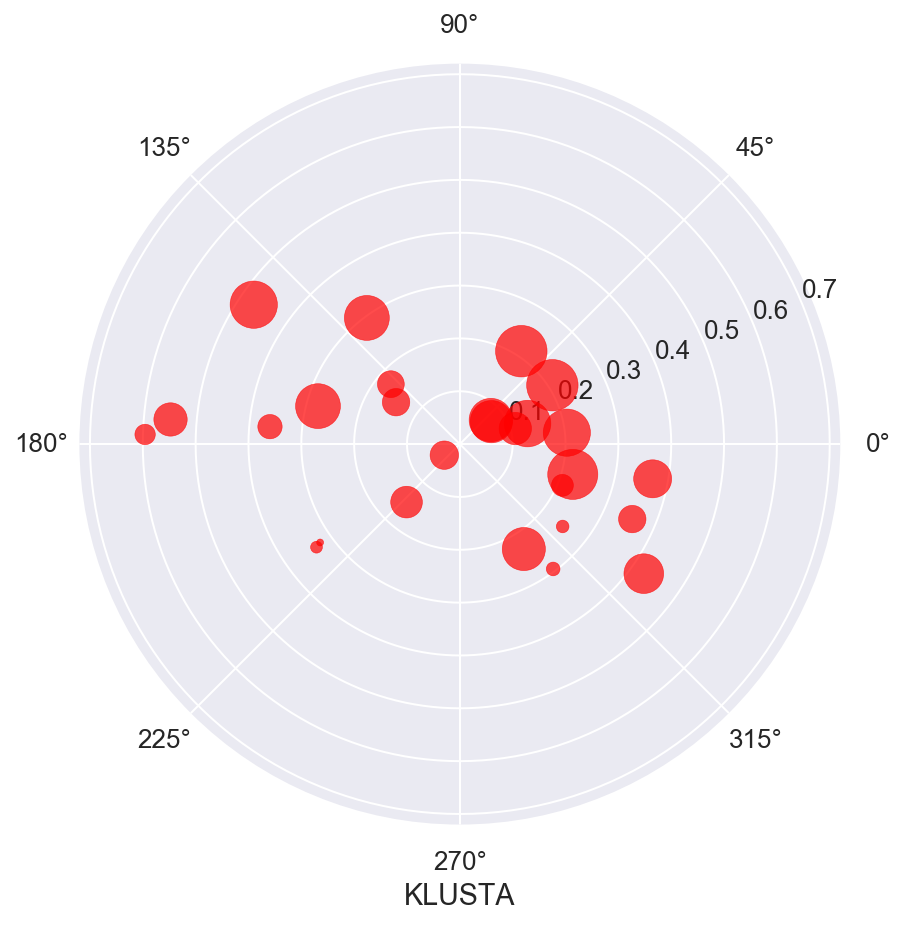

In [134]:
sns.set(font_scale=1.3)
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter([np.mean(x) for x in calbindin.theta_mean_phase_bnt.values],[np.mean(x) for x in calbindin.theta_strength_bnt.values],c='r',s=(calbindin.grid_score_bnt*500).astype(int),alpha=.7,label='Calbindin')
ax.scatter([np.mean(x) for x in stellate.theta_mean_phase_bnt.values],[np.mean(x) for x in stellate.theta_strength_bnt.values],c='r',s=(stellate.grid_score_bnt*500).astype(int),alpha=.7,label='Stellate')
ax.scatter([np.mean(x) for x in rest.theta_mean_phase_bnt.values],[np.mean(x) for x in rest.theta_strength_bnt.values],c='k',s=(rest.grid_score_bnt*500).astype(int),alpha=.7,label='Unclassified')
ax.set_xlabel('KLUSTA')

### If you want a "layer2" dataset, drop the cluster_no column and proceed

In [ ]:
base_dataframe.drop('cluster_no',1,inplace=True)

In [135]:
#base_dataframe.drop(['theta_strength','theta_mean_phase','phase_stats_mean','phase_stats_mvl'],1,inplace=True)

In [ ]:
psql = psql_neuroballs(base_dataframe)
psql.retrieve_data()

In [ ]:
base_dataframe = psql.data()

In [ ]:
base_dataframe.dropna(subset=['phase_stats_mvl','phase_stats_mean'],inplace=True)

In [ ]:
calbindin = base_dataframe[base_dataframe.calbindin == 1]
stellate = base_dataframe[base_dataframe.calbindin == 0]
rest = base_dataframe[pd.isnull(base_dataframe.calbindin)]

In [ ]:
# scatter 
sns.set(font_scale=1.3)
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.phase_stats_mean.values.astype(float),calbindin.phase_stats_mvl.values.astype(float),c='r',s=26,alpha=.7,label='Calbindin')
ax.scatter(stellate.phase_stats_mean.values.astype(float),stellate.phase_stats_mvl.values.astype(float),c='b',s=26,alpha=.7,label='Stellate')
ax.scatter(rest.phase_stats_mean.values.astype(float),rest.phase_stats_mvl.values.astype(float),c='k',s=26,alpha=.7,label='Unclassified')
ax.set_xlabel('KLUSTA')
#ax.set_ylim(0,0.85)

ax = figure.add_subplot(1,2,2,projection='polar')
ax.scatter(calbindin.theta_mean_phase.values.astype(float),calbindin.theta_strength.values.astype(float),c='r',s=26,alpha=.7,label='Calbindin')
ax.scatter(stellate.theta_mean_phase.values.astype(float),stellate.theta_strength.values.astype(float),c='b',s=26,alpha=.7,label='Stellate')
ax.scatter(rest.theta_mean_phase.values.astype(float),rest.theta_strength.values.astype(float),c='k',s=26,alpha=.7,label='Unclassified')
ax.set_xlabel('BNT')

ax.legend(loc=1)
#plt.axis('square')

In [ ]:
# scatter 
sns.set(font_scale=1.3)
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1)
ax.scatter(base_dataframe.phase_stats_mvl,base_dataframe.theta_strength,c='k',s=26,lw=0,alpha=.77)
ax.set_xlabel('KLUSTA')
ax.set_ylabel('BNT')
ax.set_title('Theta tuning strength')
ax = figure.add_subplot(1,2,2)
ax.scatter(base_dataframe.phase_stats_mean,base_dataframe.theta_mean_phase,c='k',s=26,lw=0,alpha=.77)
ax.set_title('Theta tuning angle')
ax.set_xlabel('KLUSTA')
ax.set_ylabel('BNT')
plt.axis('square')

### Ratemaps

Filter stuff and so  on ... *

In [14]:
base_dataframe.sort_values(by='grid_score_bnt',ascending=False,inplace=True)

In [18]:
cut_off = 0.3
only_grids = base_dataframe[base_dataframe.grid_score_bnt > cut_off]
only_not_grids = base_dataframe[base_dataframe.grid_score_bnt < cut_off]
#only_grids.sort_values(by='phase_stats_mvl',ascending=False,inplace=True)


In [19]:
base_dataframe.head()

tetrode_no animal_id n_drive_user          session_ts  cluster_no  \
102           5     72254      davidcr 2017-07-03 17:32:44          23   
45            5     72254      davidcr 2017-07-05 13:28:01          29   
176           5     72254      davidcr 2017-06-21 09:35:55          22   
67            5     72254      davidcr 2017-06-14 14:29:14          20   
95            7     72254      davidcr 2017-07-06 14:49:22          13   

    session_name                             spiketimes_cluster_bnt  \
102   03072017s1  [3.72854166667, 4.02352083333, 4.26154166667, ...   
45    05072017s1  [6.52029166667, 6.679875, 13.1061666667, 13.71...   
176   21062017s1  [0.0926875, 0.2103125, 0.2470625, 0.9977291666...   
67    14062017s2  [0.0100625, 0.160520833333, 0.223375, 1.547687...   
95    06072017s1  [0.749, 1.35108333333, 1.36333333333, 1.459916...   

                                  theta_mean_phase_bnt  \
102  [-0.288550078139, -0.287766262836, -0.28878878...   
45   [-0.588012666876, -0.587109690775, -0.58828843...   
176  [-0.376165172806, -0.375535897357, -0.37626708...   
67   [-0.630004158587, -0.629548738862, -0.63025714...   
95   [1.6486492303, 1.64919456219, 1.64841857257, 1...   

                                    theta_strength_bnt  sparsity_bnt  \
102  [0.440224636226, 0.440258931254, 0.44019504394...      0.592672   
45   [0.349985971429, 0.350029433568, 0.34999835326...      0.408792   
176  [0.328699704008, 0.328845571898, 0.32880717439...      0.586268   
67   [0.224916971264, 0.224828449369, 0.22479230350...      0.435079   
95   [0.200928188678, 0.200987879475, 0.20089590623...      0.495299   

                           ...                          speed_cutoff  \
102                        ...                                   5.0   
45                         ...                                   5.0   
176                        ...                                   5.0   
67                         ...                                   5.0   
95                         ...                                   5.0   

     bin_size nbins sigma_time  \
102       2.0  40.0        2.0   
45        2.0  40.0        2.0   
176       2.0  40.0        2.0   
67        2.0  40.0        2.0   
95        2.0  40.0        2.0   

                                                yedges  \
102  [4.0, 14.175, 24.35, 34.525, 44.7, 54.875, 65....   
45   [0.0251206738792, 10.0317924106, 20.0384641473...   
176  [7.91539477216, 18.5340181615, 29.1526415508, ...   
67   [4.0, 14.275, 24.55, 34.825, 45.1, 55.375, 65....   
95   [3.84087001839, 13.9896023677, 24.1383347171, ...   

                                                xedges  calc  sigma_rate  \
102  [24.0, 33.5, 43.0, 52.5, 62.0, 71.5, 81.0, 90....  True         2.0   
45   [29.584105857, 39.1042914465, 48.6244770361, 5...  True         2.0   
176  [-6.63521699872, 2.79888139363, 12.232979786, ...  True         2.0   
67   [0.0, 9.125, 18.25, 27.375, 36.5, 45.625, 54.7...  True         2.0   
95   [15.8506719986, 25.414560554, 34.9784491094, 4...  True         2.0   

     box_size_cm                                     masked_ratemap  
102         80.0  [[0.0902636876627, 0.0820075427646, 0.07369100...  
45          80.0  [[0.0255351318663, 0.0220687692253, 0.01856310...  
176         80.0  [[0.0541636143449, 0.0554387440786, 0.05632619...  
67          80.0  [[0.00730796053062, 0.0069602744073, 0.0065901...  
95          80.0  [[0.0305322375829, 0.029236546411, 0.027755386...  

[5 rows x 66 columns]


Generating plot ...


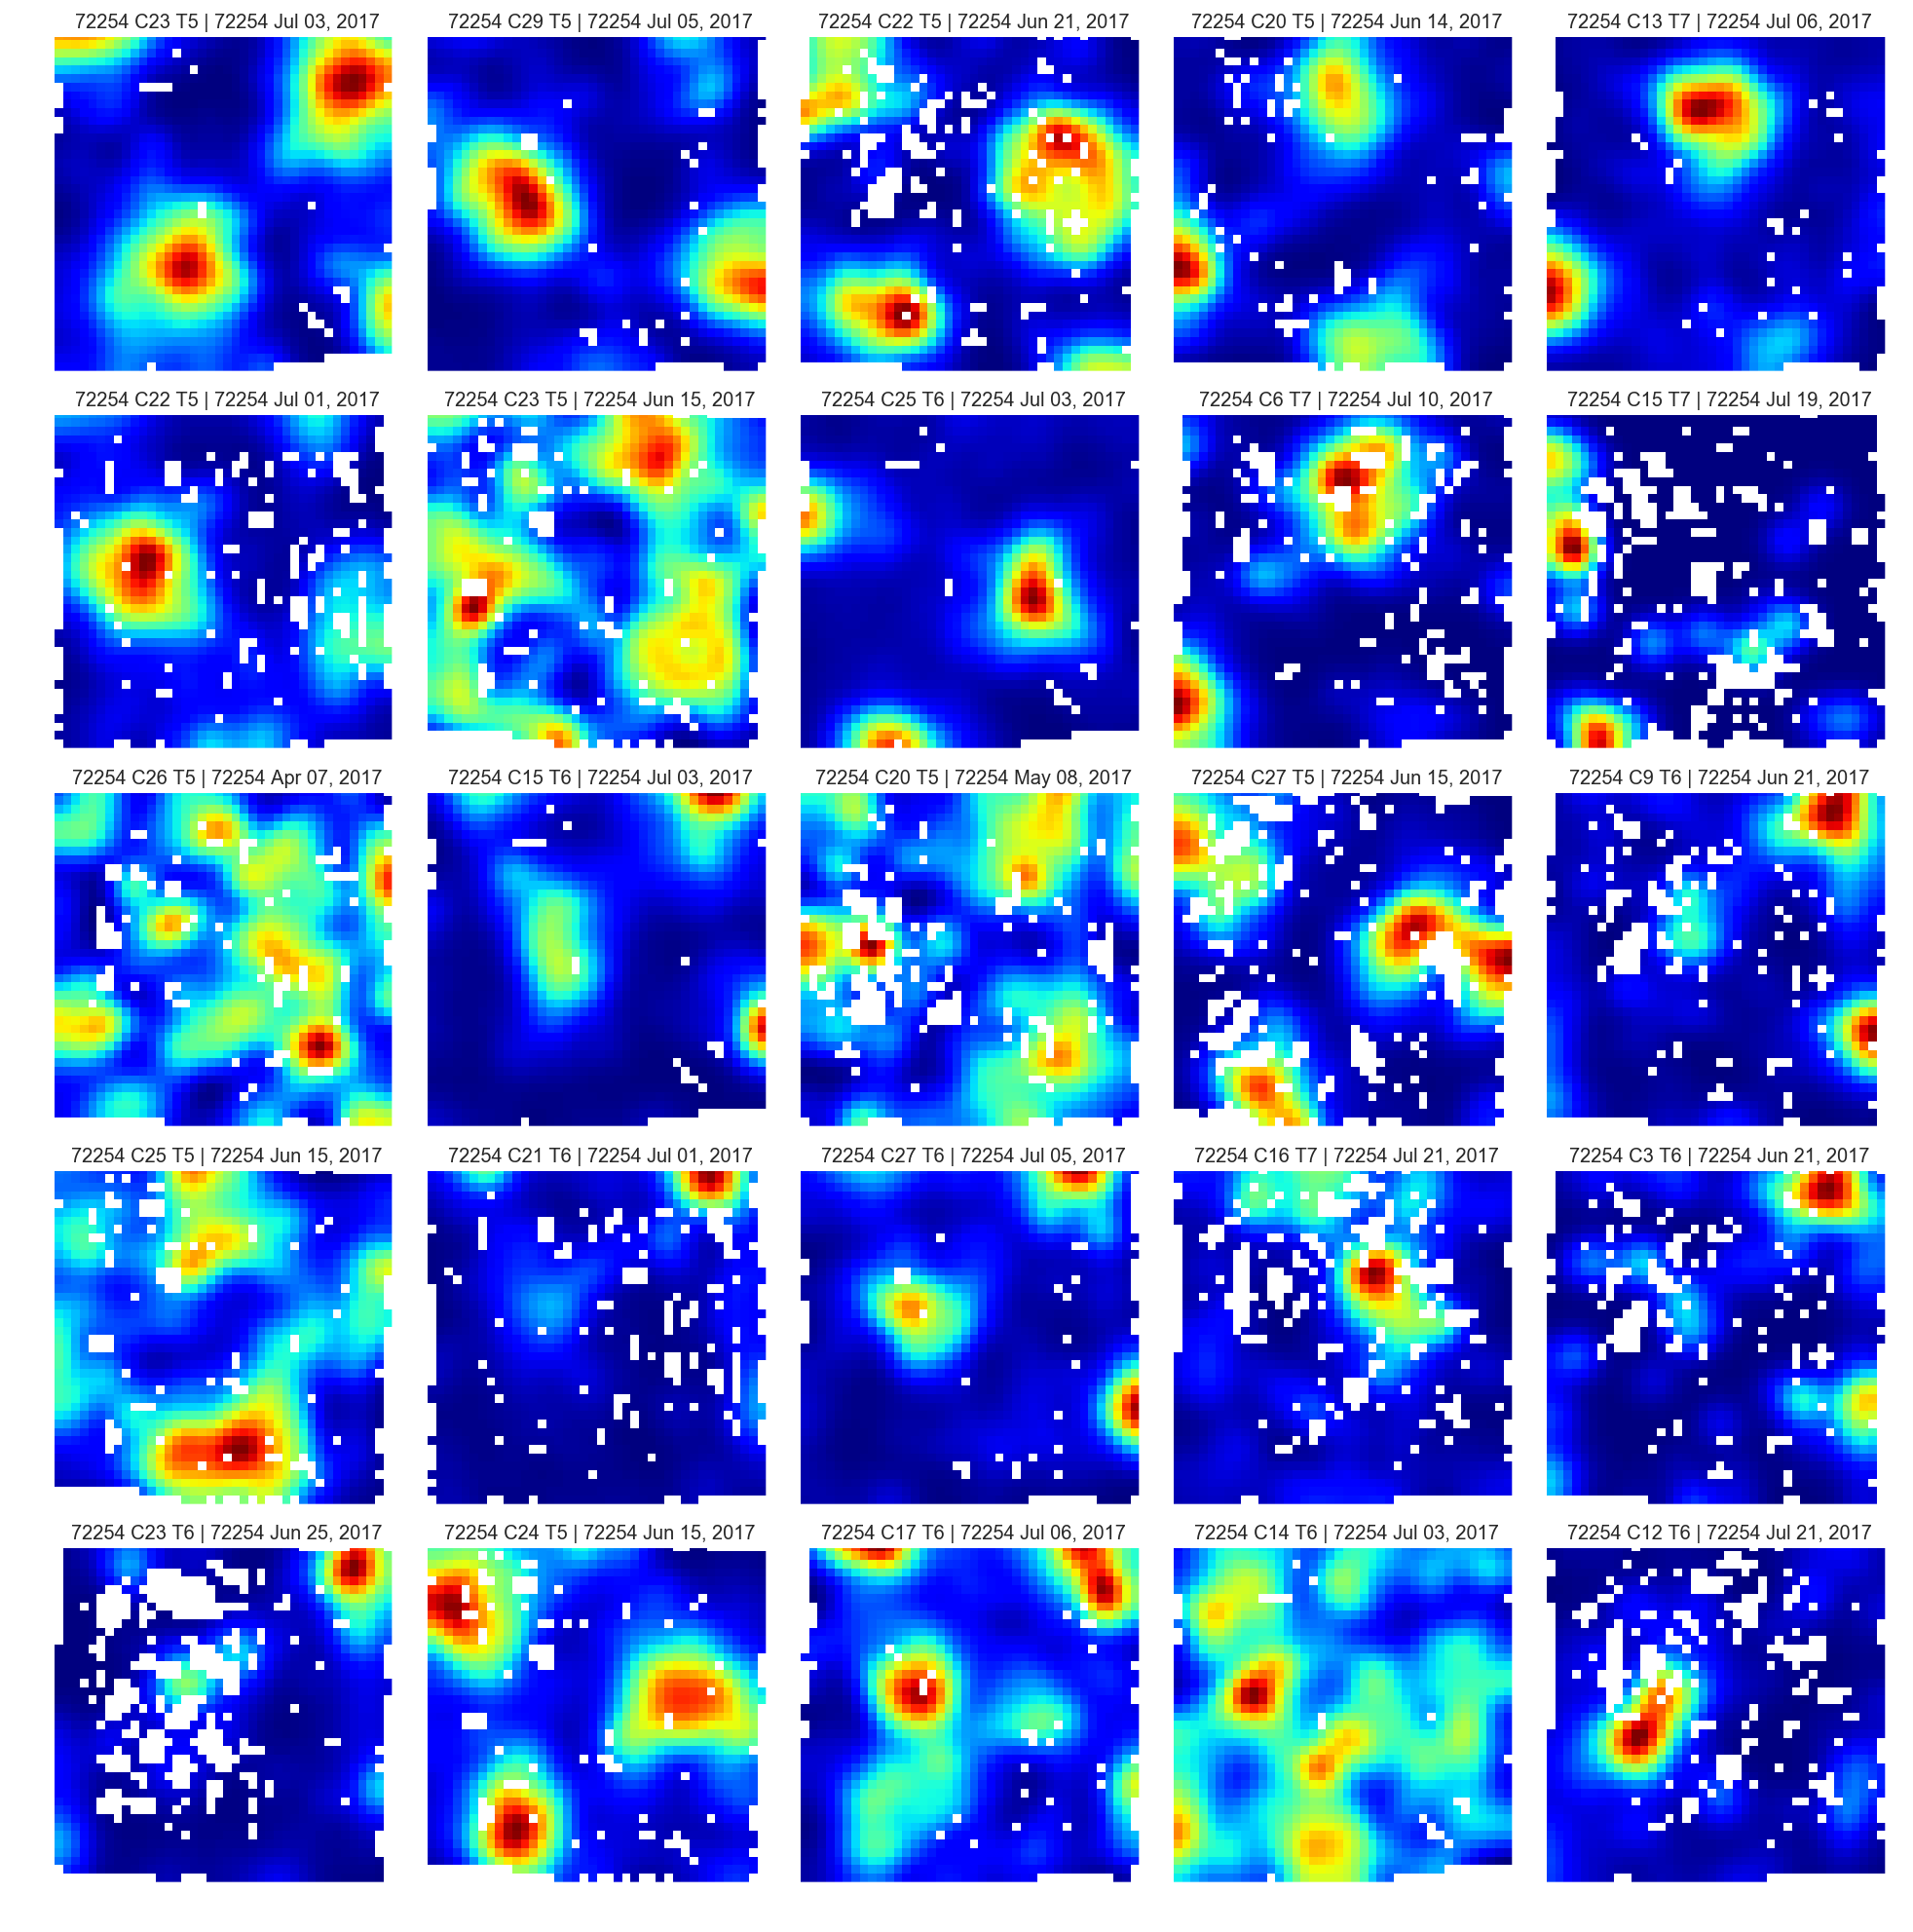

In [20]:
draw_ratemaps(only_grids,'masked_ratemap_bnt',25,0)


Generating plot ...


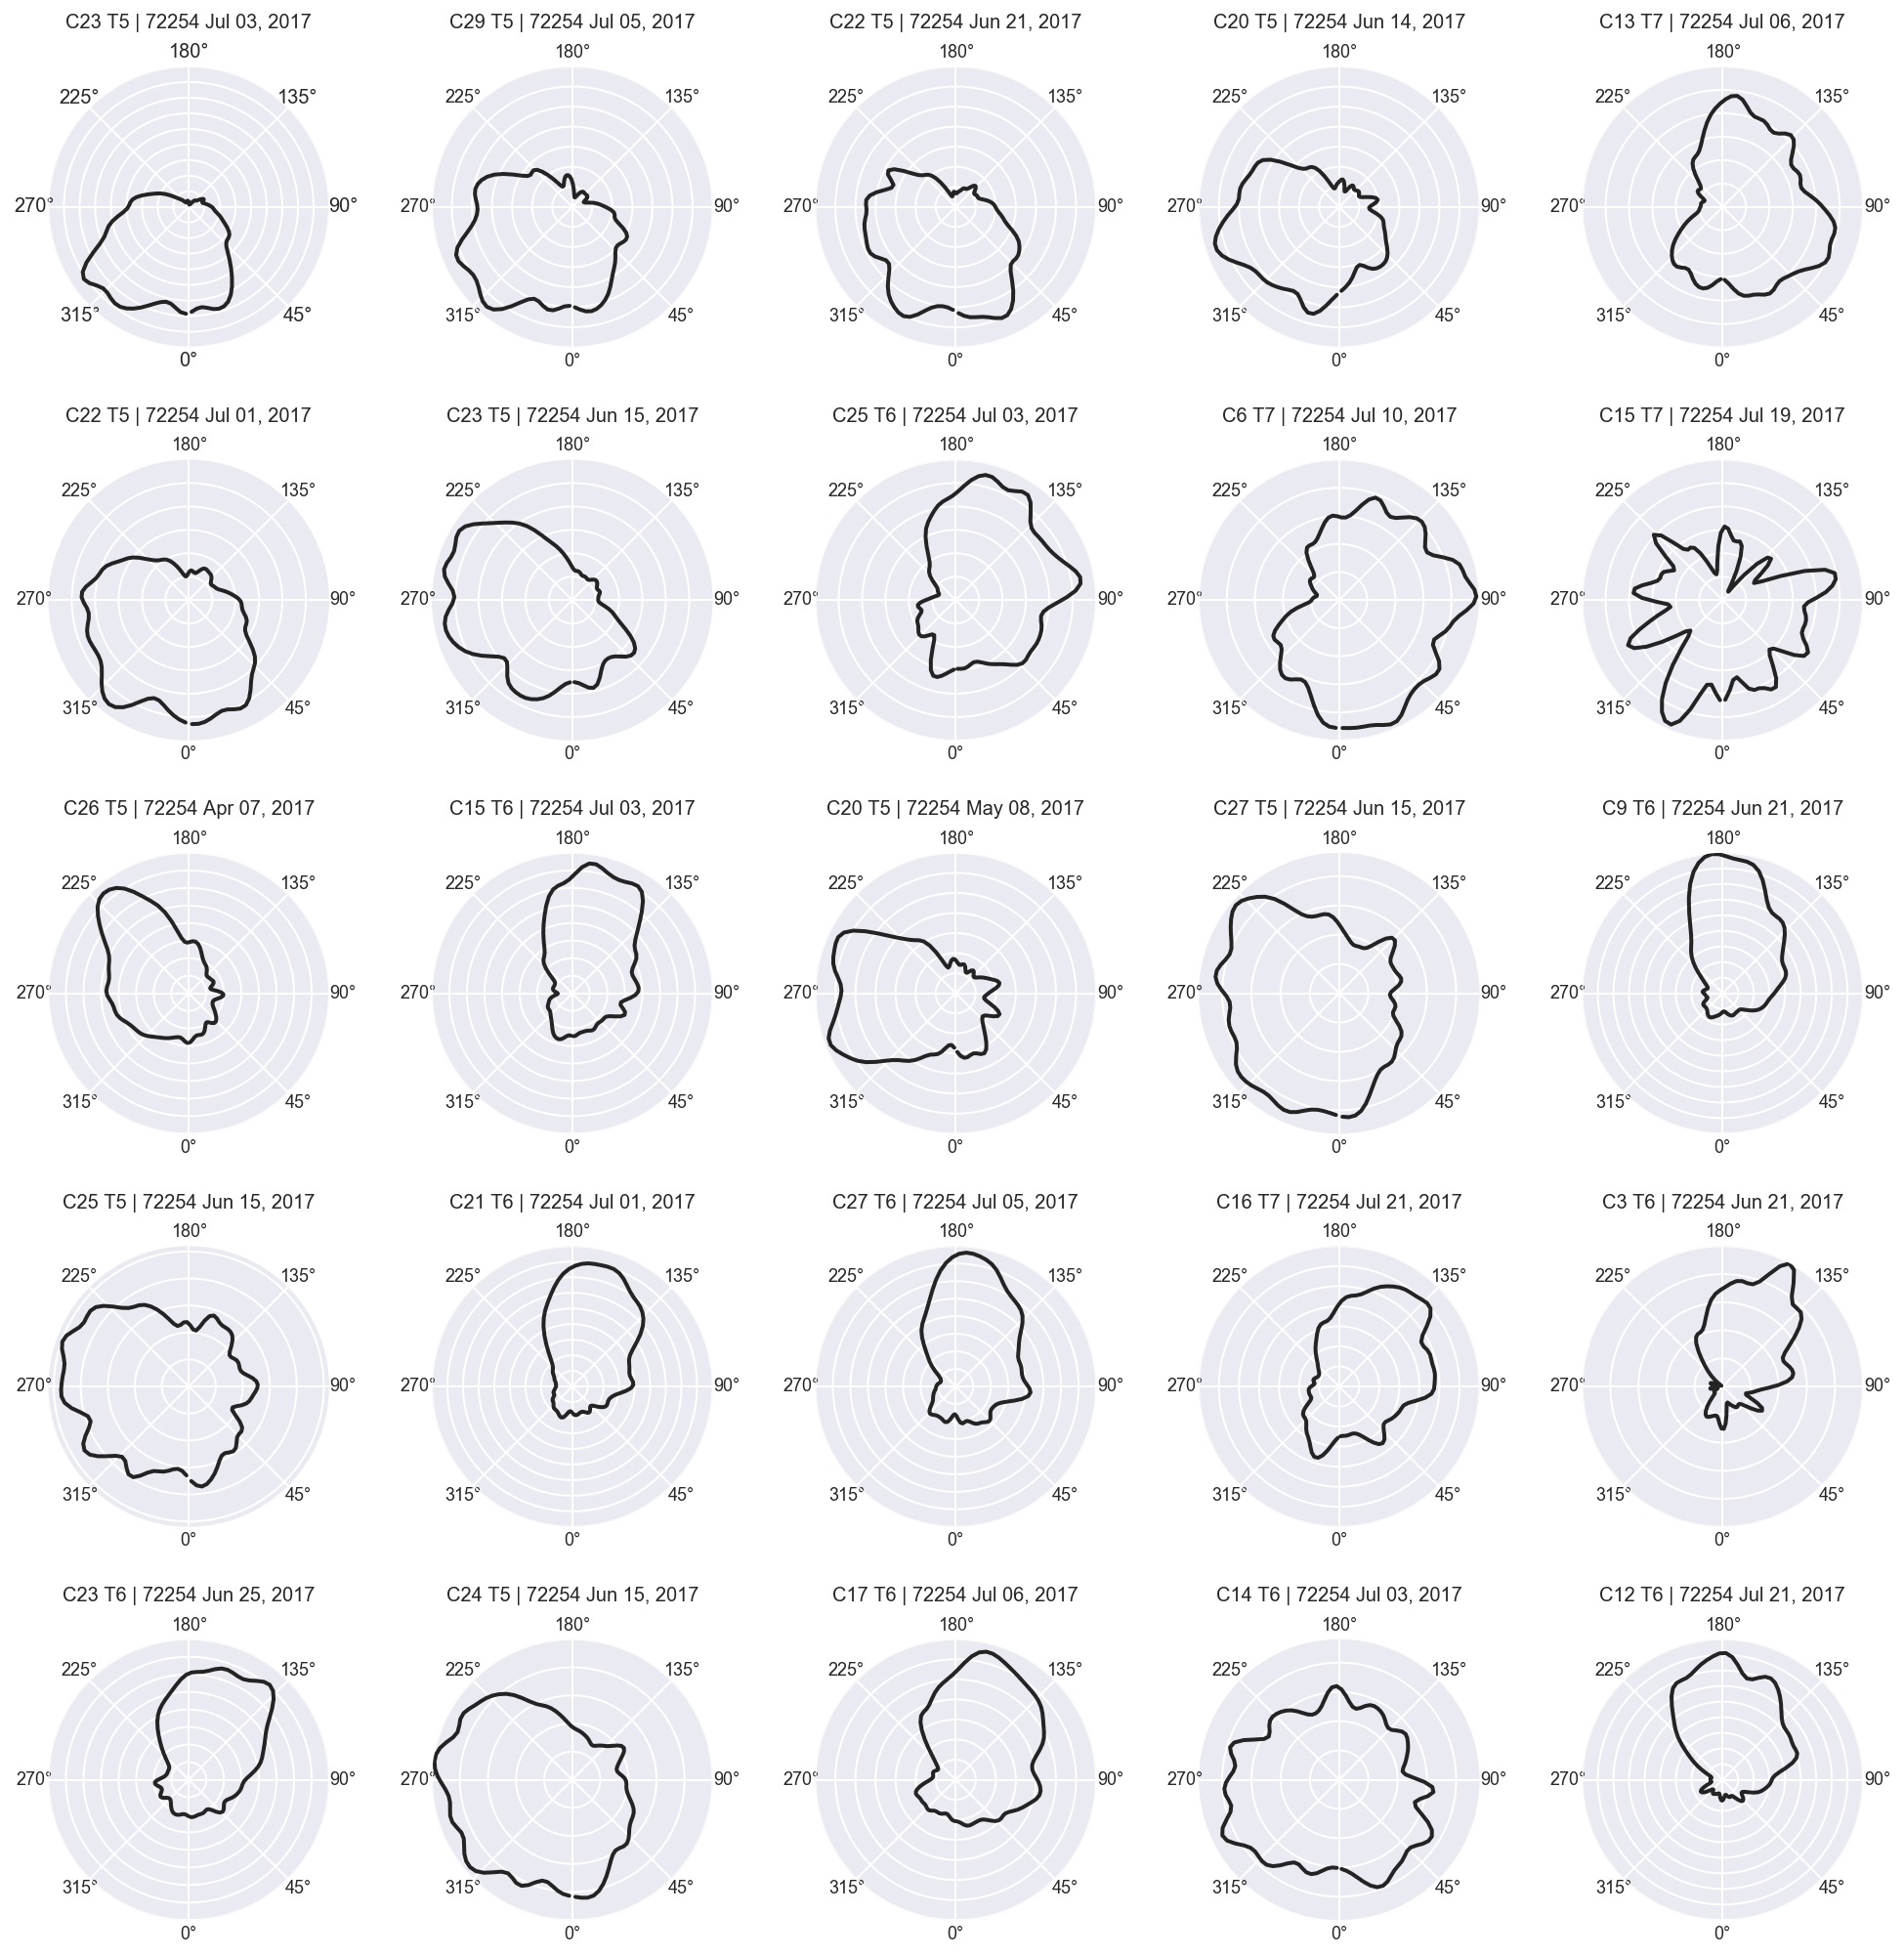

In [21]:

draw_tuning_curves(only_grids,['bins_angle_center_phase','hist_angle_smooth_phase'],25,0,'S')


Generating plot ...


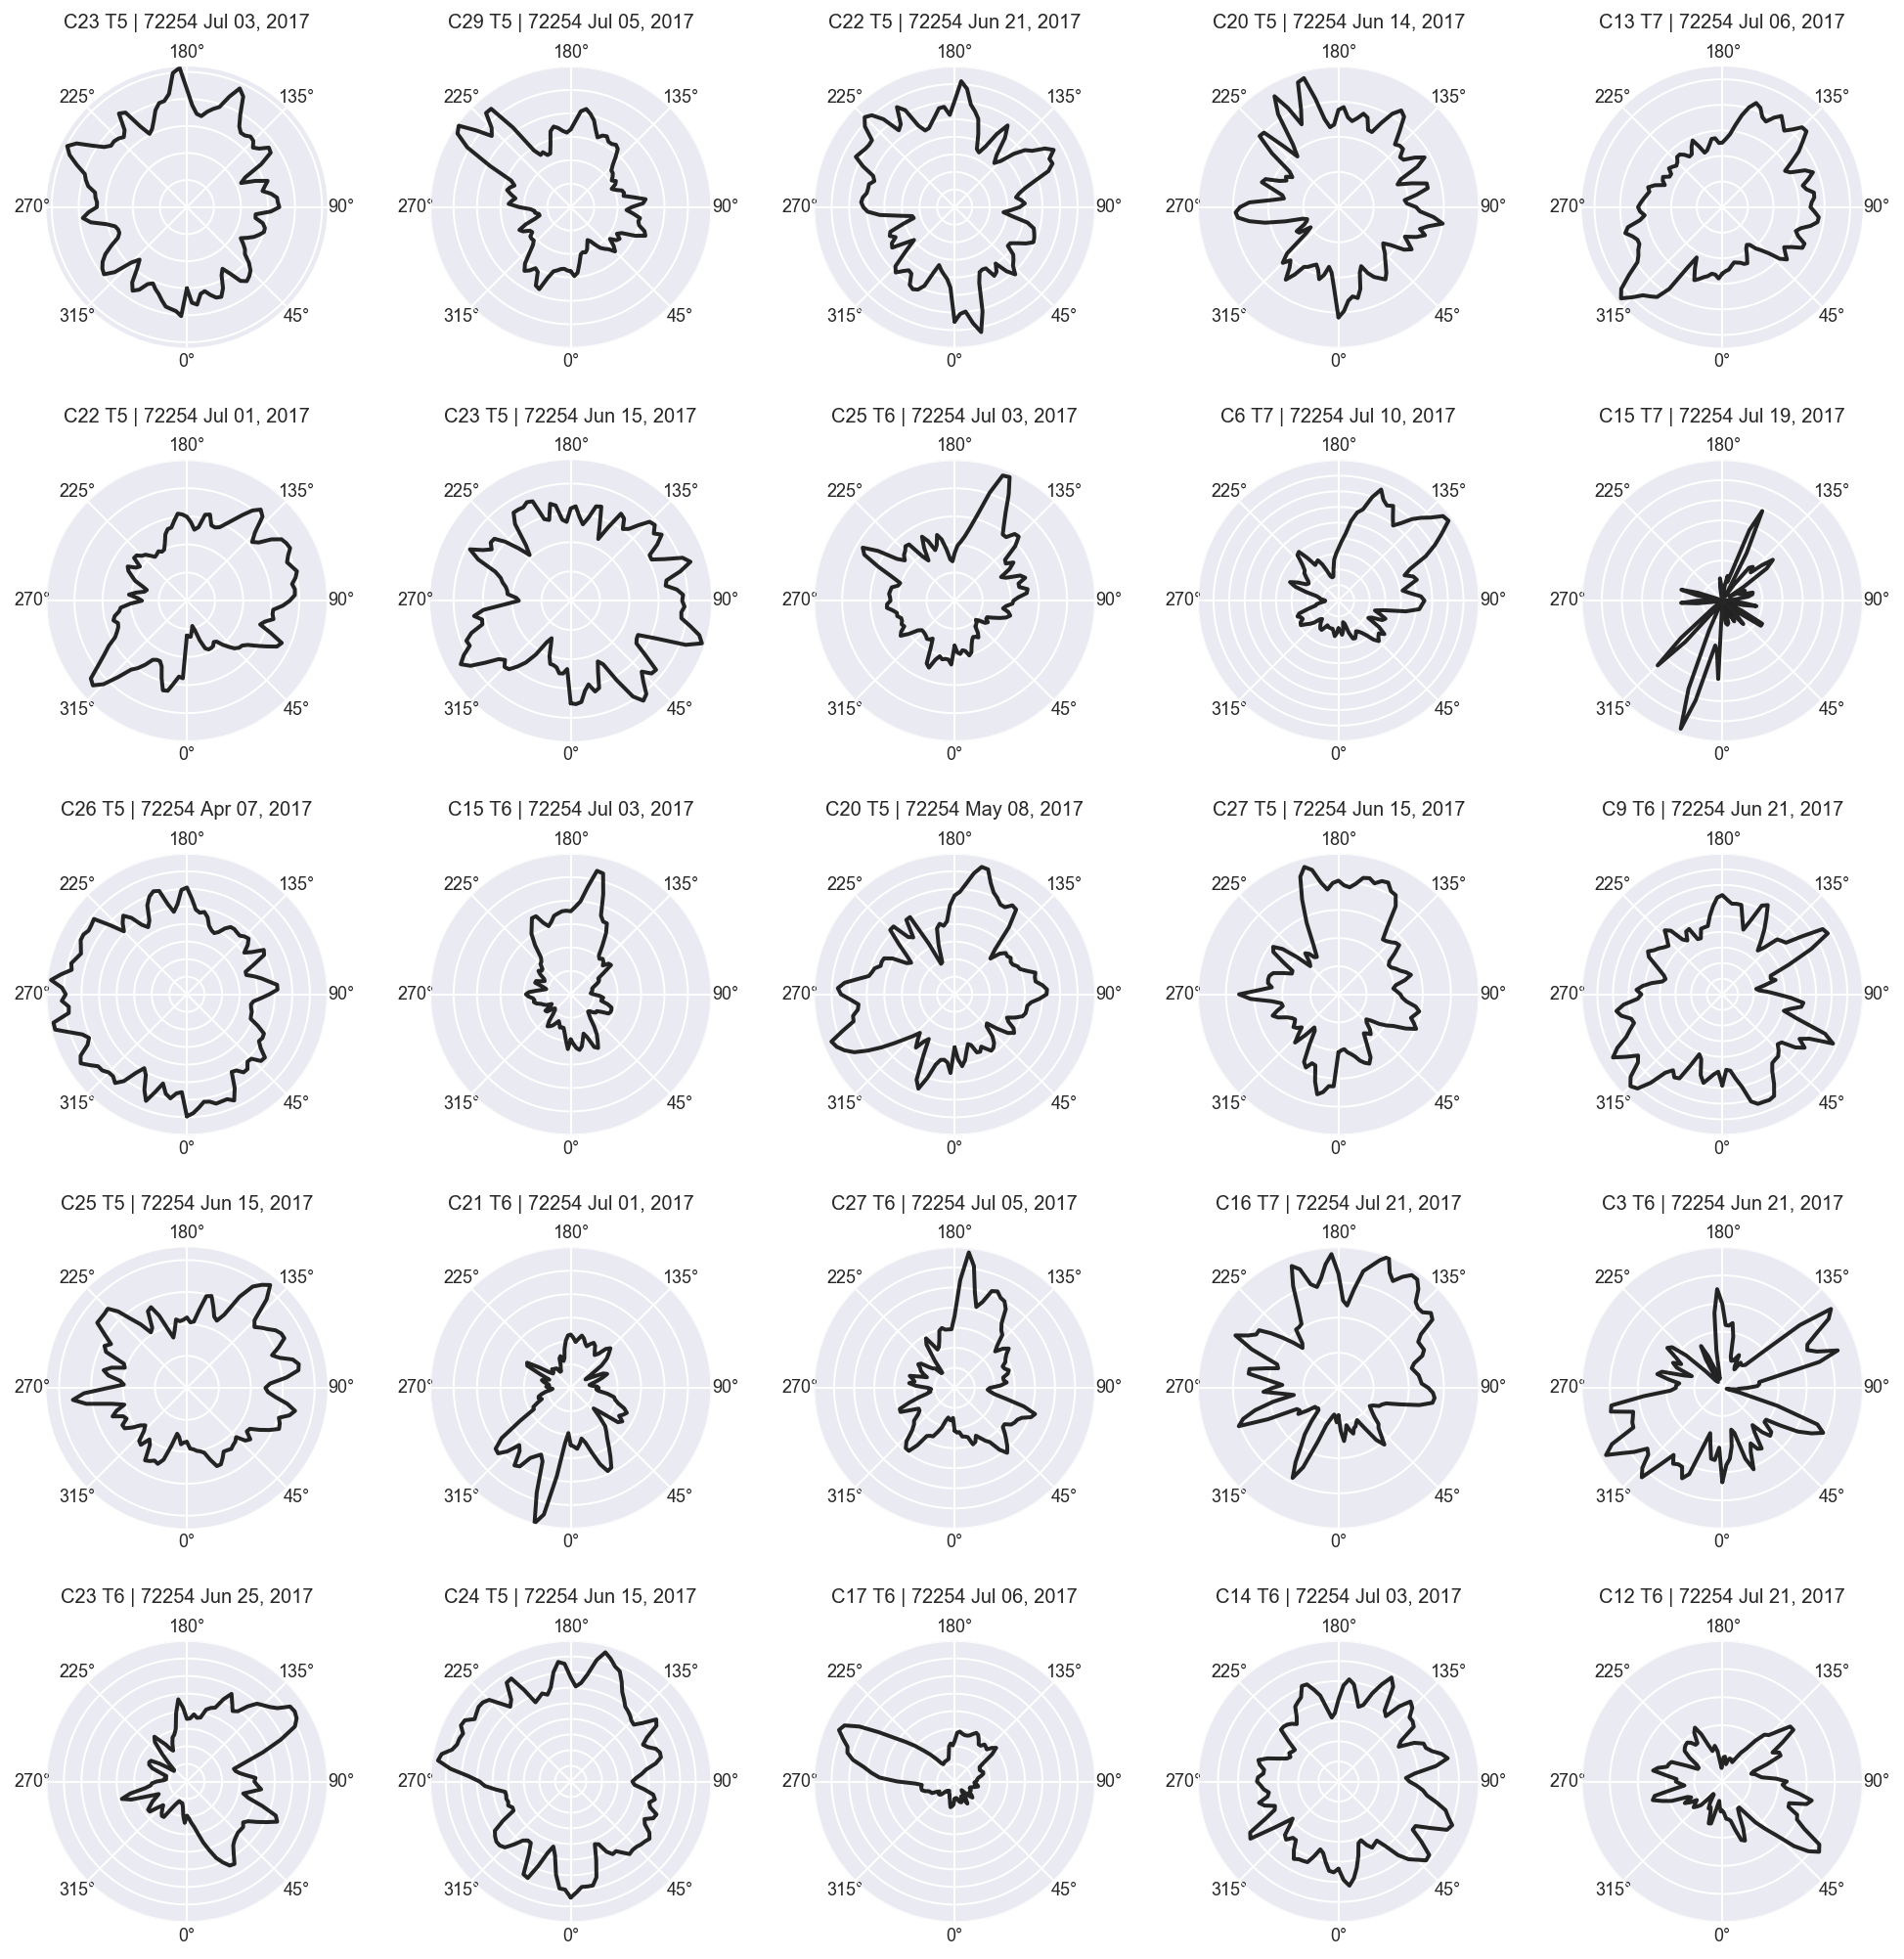

In [23]:
draw_tuning_curves(only_grids,['bins_angle_center_bnt','hist_angle_smooth_bnt'],25,0,'S')


Generating plot ...


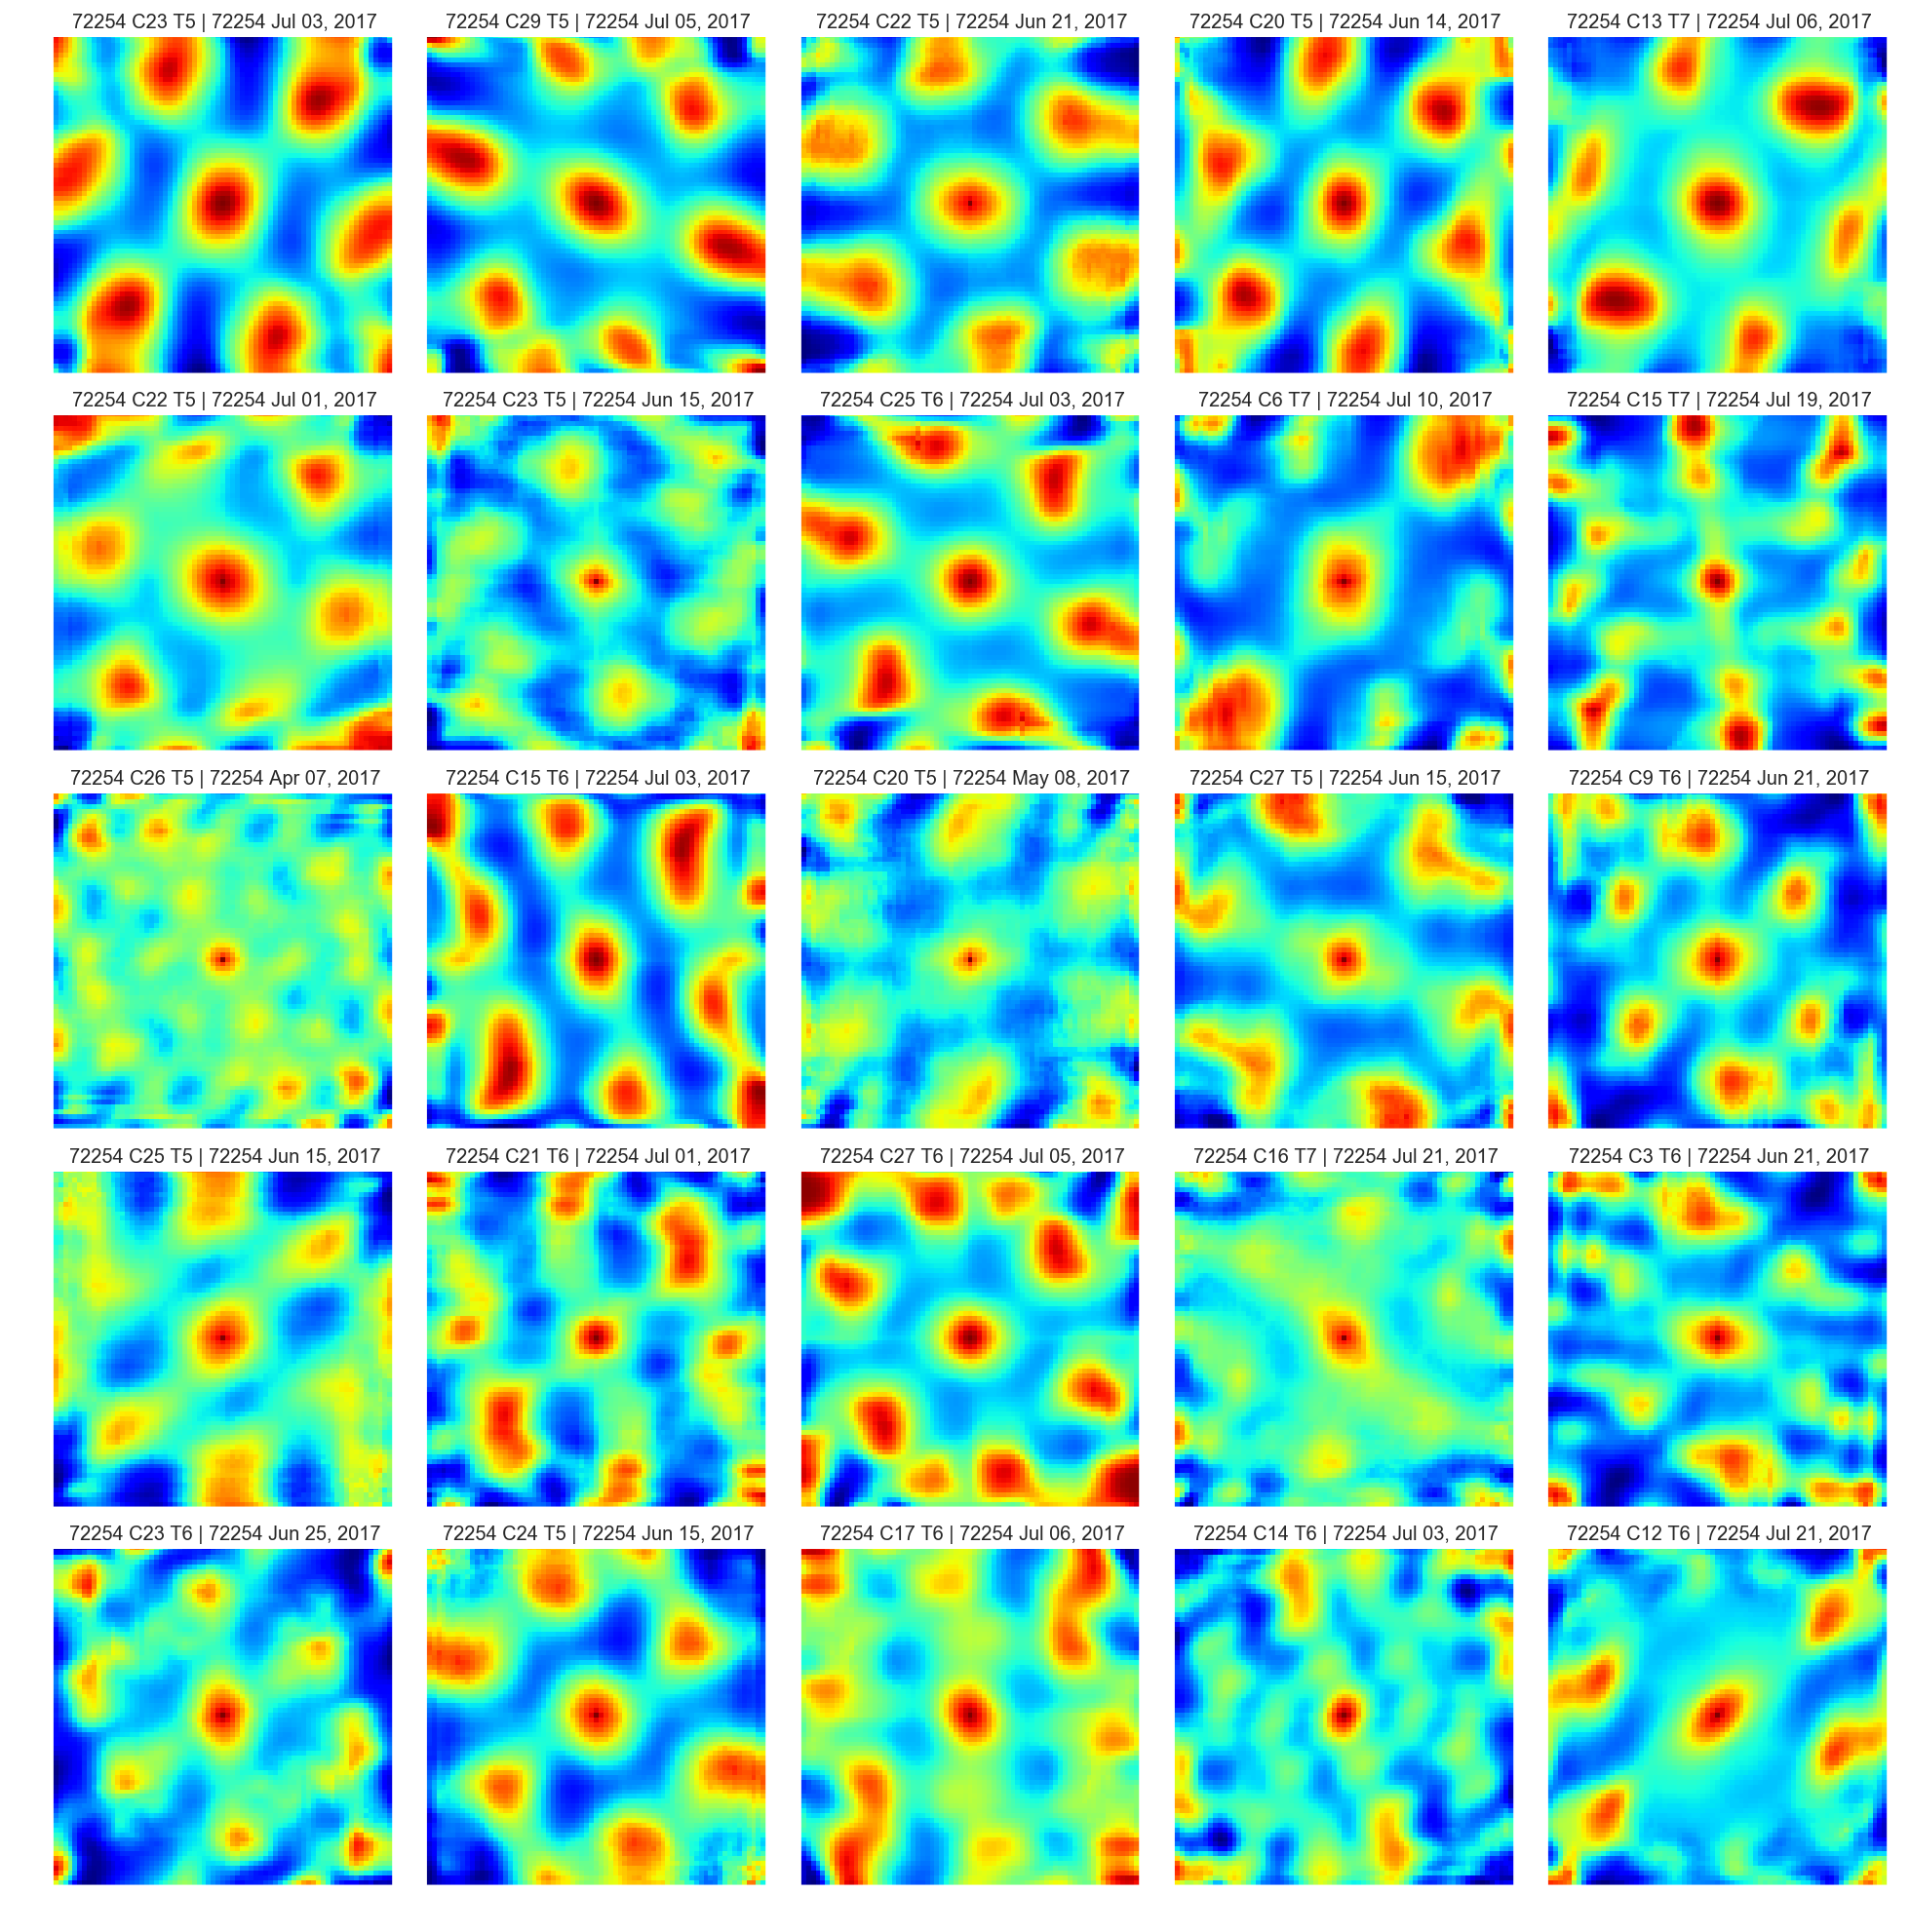

In [22]:
draw_ratemaps(only_grids,'autocorr_bnt',25,0)

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

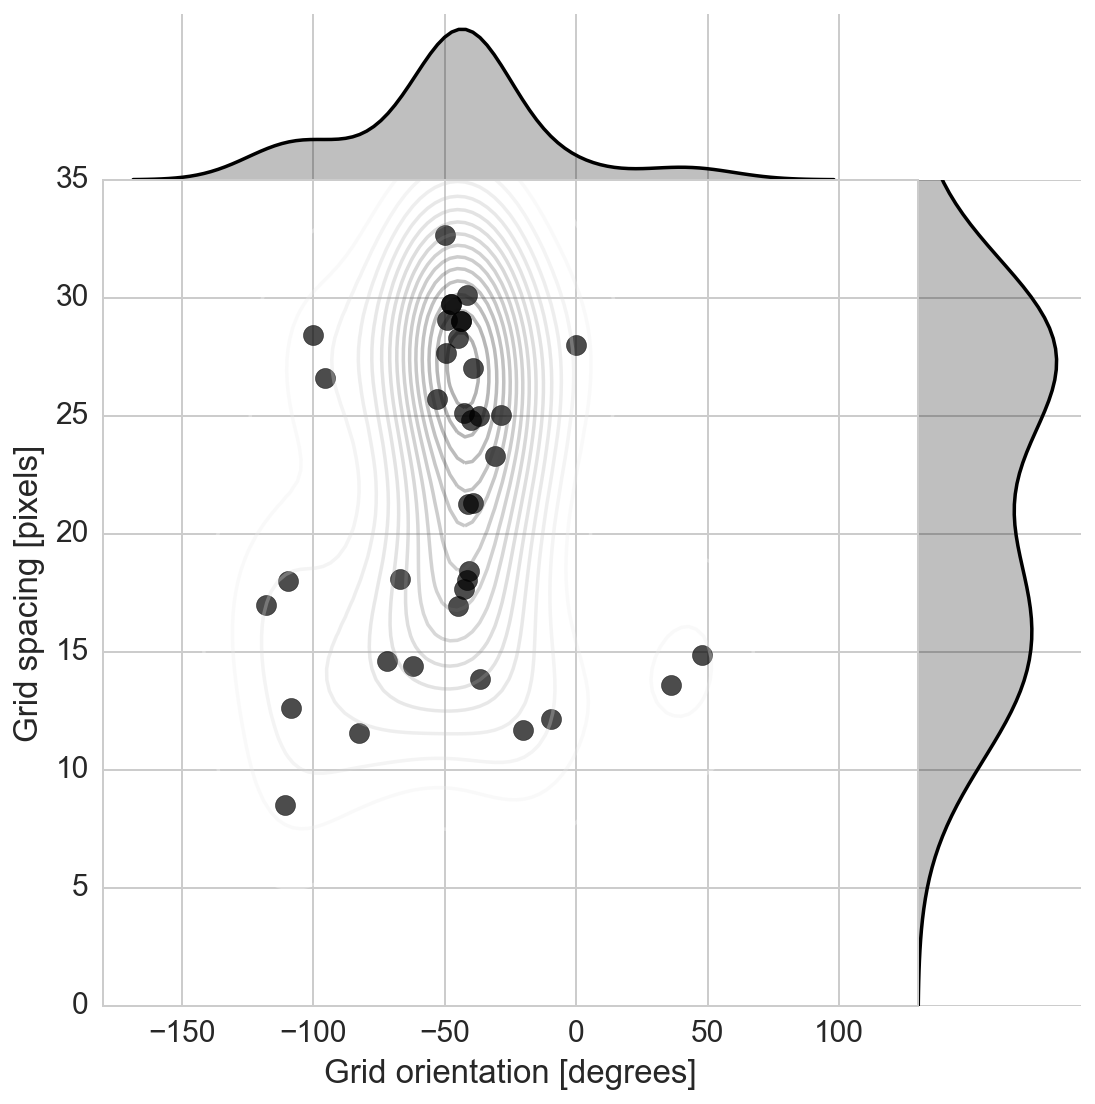

<function matplotlib.pyplot.show>

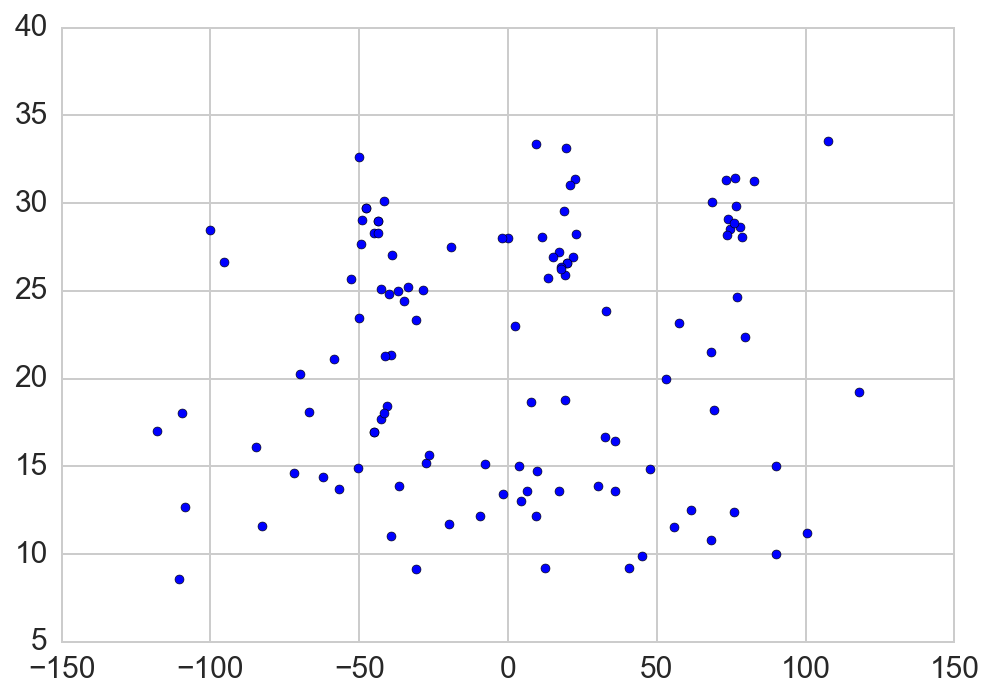

In [26]:
sns.set(font_scale=1.5) 
sns.set_style('whitegrid')



only_grids['first_grid_orientation'] = [x[0] for x in only_grids['gridstats_orientation_bnt']]
only_grids['first_grid_spacing'] = [x[0] for x in only_grids['gridstats_spacing_bnt']]
only_grids['second_grid_orientation'] = [x[1] for x in only_grids['gridstats_orientation_bnt']]
only_grids['second_grid_spacing'] = [x[1] for x in only_grids['gridstats_spacing_bnt']]
only_grids['third_grid_orientation'] = [x[2] for x in only_grids['gridstats_orientation_bnt']]
only_grids['third_grid_spacing'] = [x[2] for x in only_grids['gridstats_spacing_bnt']]
g = sns.jointplot(only_grids['first_grid_orientation'],only_grids['first_grid_spacing'], kind="kde", size=8,
                  space=0,color='k',shade=False,n_levels=15,alpha=.3,stat_func=None)
g.plot_joint(plt.scatter, marker='o', c='k', s=100,alpha=.7)
g.ax_joint.set(xlim=(-180, 130), ylim=(0, 35),xlabel='Grid orientation [degrees]',ylabel='Grid spacing [pixels]')

plt.show(g)
plt.scatter(only_grids['first_grid_orientation'], only_grids['first_grid_spacing'])
plt.scatter(only_grids['second_grid_orientation'], only_grids['second_grid_spacing'])
plt.scatter(only_grids['third_grid_orientation'], only_grids['third_grid_spacing'])
#plt.scatter(ab,bc)
plt.show


In [24]:
only_grids.dropna(subset=['theta_mean_phase_bnt','theta_strength_bnt','grid_score_bnt'],inplace=True)

calbindin = only_grids[only_grids.calbindin_bnt == 1]
stellate = only_grids[only_grids.calbindin_bnt == 0]
rest = only_grids[pd.isnull(only_grids.calbindin_bnt)]
print('Classifier results: {} Calbindin, {} Stellate, {} Unidentified'.format(len(calbindin),len(stellate),len(rest)))

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Classifier results: 60 Calbindin, 329 Stellate, 0 Unidentified


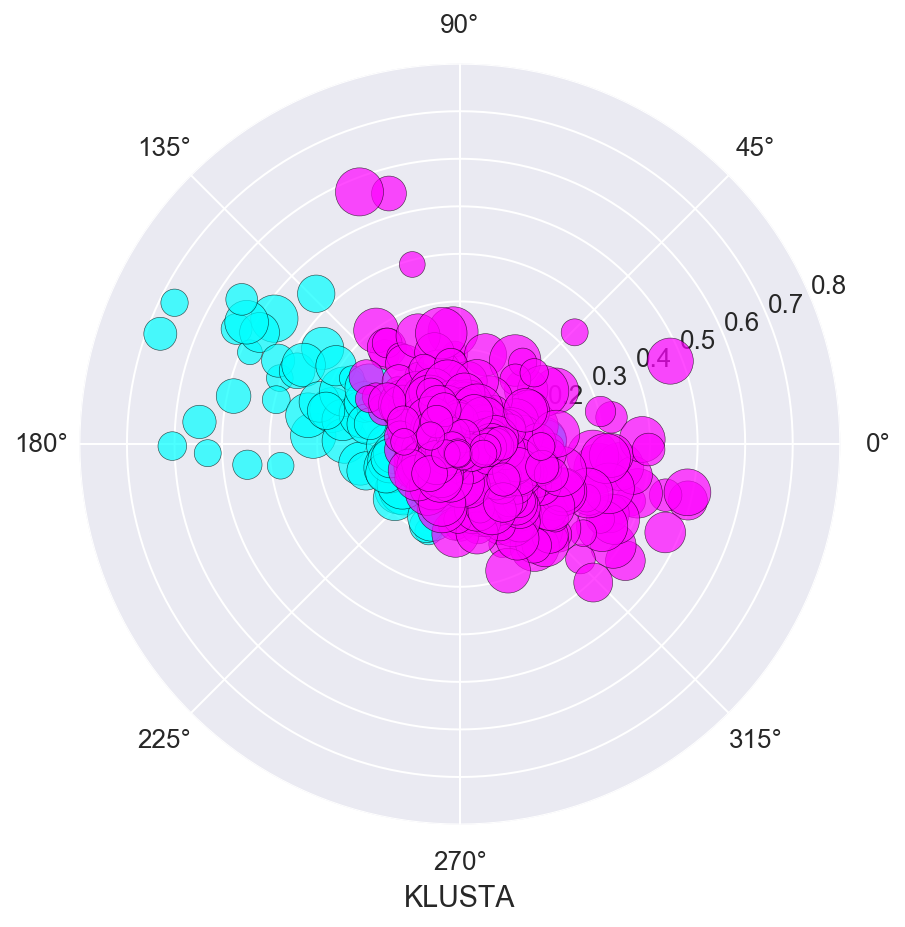

In [25]:
sns.set(font_scale=1.3)
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter([np.mean(x) for x in calbindin.theta_mean_phase_bnt.values],[np.mean(x) for x in calbindin.theta_strength_bnt.values],c='cyan',s=(calbindin.grid_score_bnt*500).astype(int),alpha=.7,label='Calbindin')
ax.scatter([np.mean(x) for x in stellate.theta_mean_phase_bnt.values],[np.mean(x) for x in stellate.theta_strength_bnt.values],c='magenta',s=(stellate.grid_score_bnt*500).astype(int),alpha=.7,label='Stellate')
ax.scatter([np.mean(x) for x in rest.theta_mean_phase_bnt.values],[np.mean(x) for x in rest.theta_strength_bnt.values],c='k',s=(rest.grid_score_bnt*500).astype(int),alpha=.7,label='Unclassified')
ax.set_xlabel('KLUSTA')

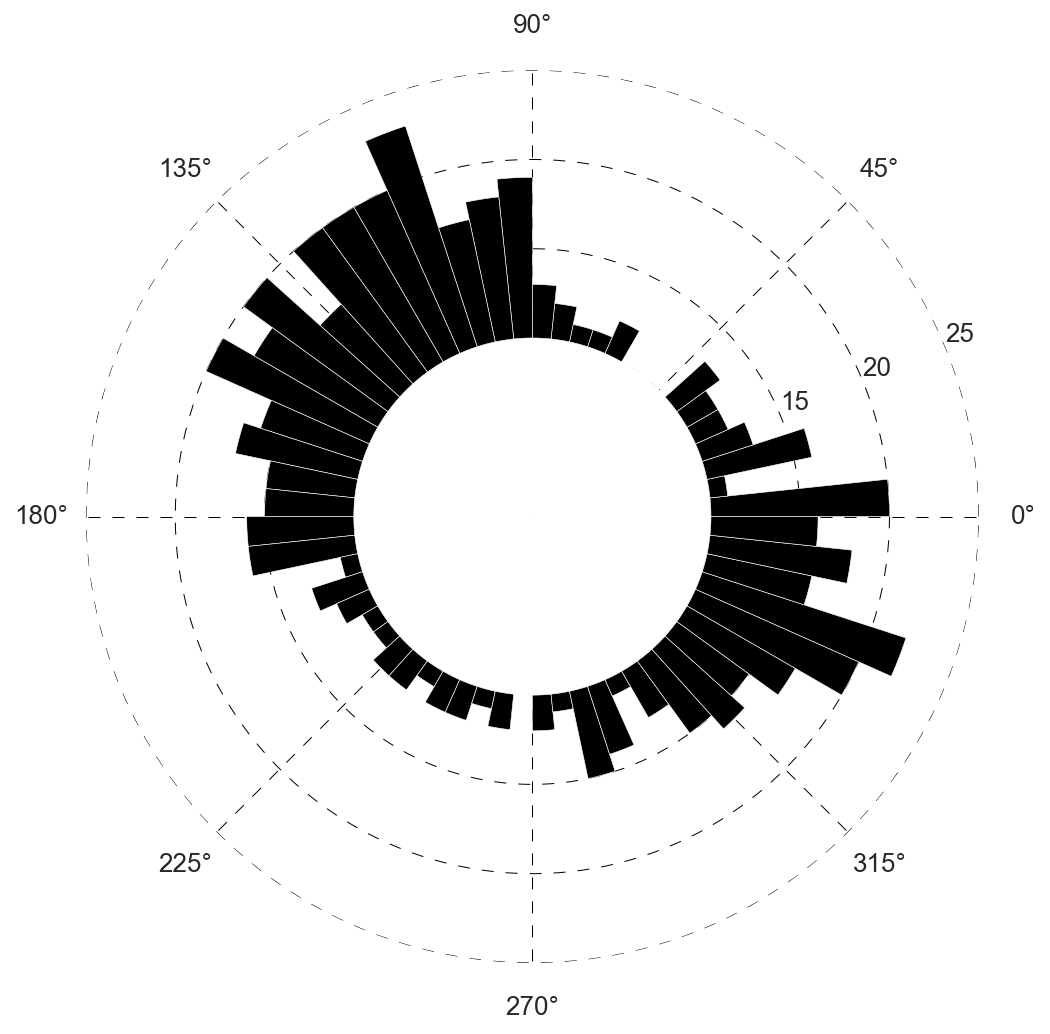

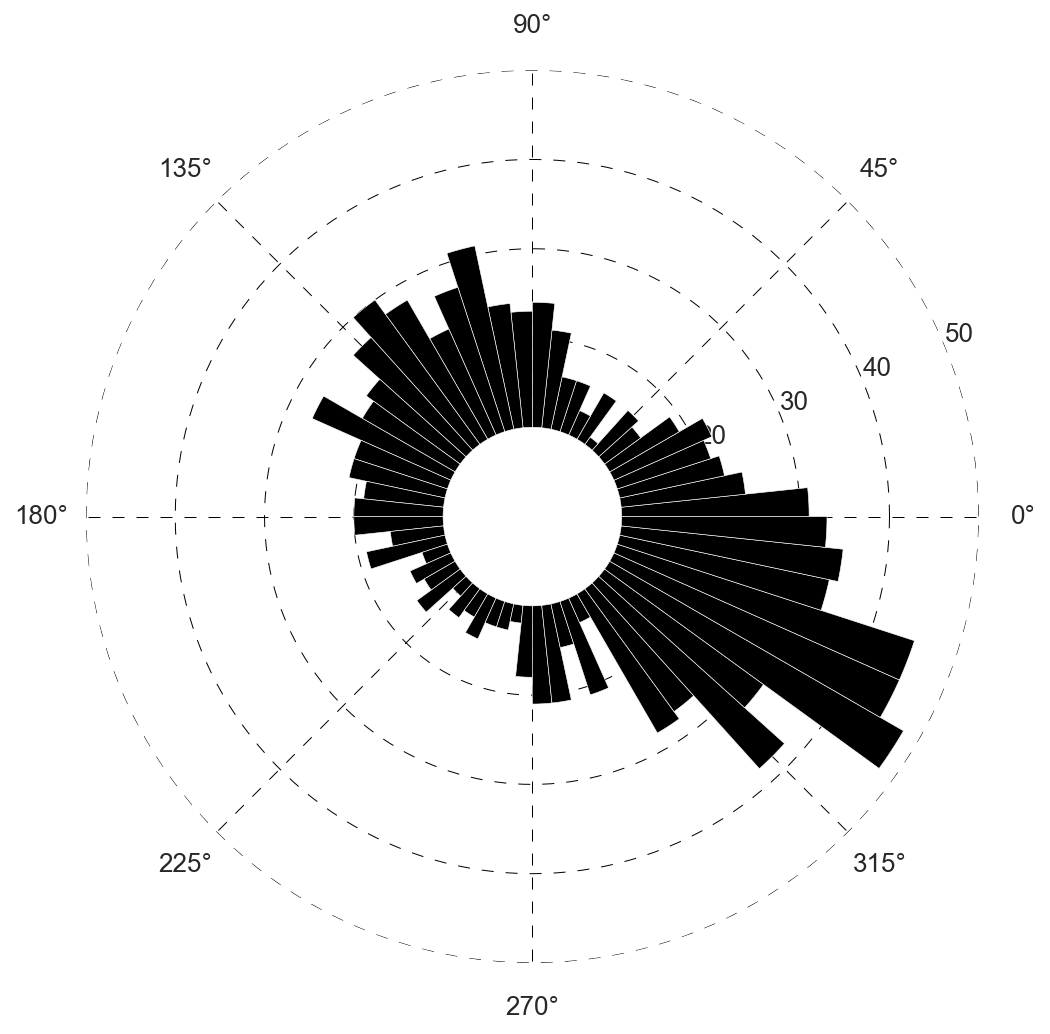

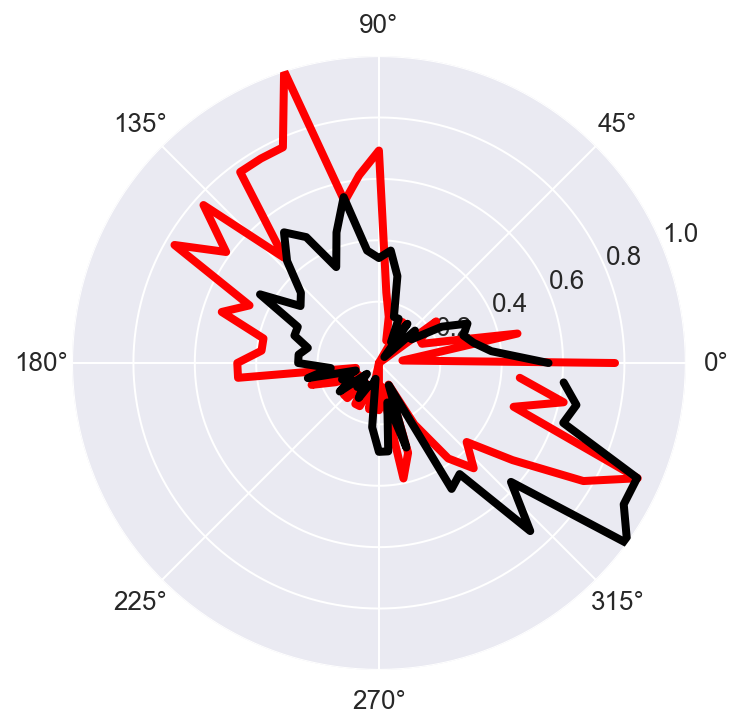

In [85]:
#filter for phase locked cells

cut_off = 0.1
only_plgrids = only_grids[only_grids.phase_stats_mvl > cut_off]
only_plnot_grids = only_not_grids[only_not_grids.phase_stats_mvl > cut_off]

arr = only_plgrids.phase_stats_mean
test = only_grids.rayleigh_p

arrnongrids = only_plnot_grids.phase_stats_mean
#arrnongrids.dropna(inplace=True)
#arr = [np.mean(x) for x in only_grids.theta_mean_phase_bnt.values]
#arr.dropna(inplace=True)


bottom = 10
N = 60
# create theta for 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
radii, tick = np.histogram(arr, bins = N)

# width of each bin on the plot
width = (2*np.pi) / N
mask = np.ones(N)*10;
# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars =ax.bar(theta, mask, color ='w', edgecolor = 'w')
bars = ax.bar(theta, radii, width=width, bottom=bottom, color ='k',edgecolor = 'w')

# set the label go clockwise and start from the top
ax.set_theta_zero_location("E")
# clockwise
ax.set_theta_direction(1)
ax.set_axis_bgcolor('w')
ax.grid(color='k', linestyle='--', linewidth=0.5)
# set the label



plt.show()

# create theta for 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
radii2, tick = np.histogram(arrnongrids, bins = N)

# width of each bin on the plot
width = (2*np.pi) / N
mask = np.ones(N)*10;
# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars =ax.bar(theta, mask, color ='w', edgecolor = 'w')
bars = ax.bar(theta, radii2, width=width, bottom=bottom, color ='k',edgecolor = 'w')

# set the label go clockwise and start from the top
ax.set_theta_zero_location("E")
# clockwise
ax.set_theta_direction(1)
ax.set_axis_bgcolor('w')
ax.grid(color='k', linestyle='--', linewidth=0.5)
# set the label



plt.show()

ax = plt.subplot(111, projection='polar')
radii = np.true_divide(radii, max(radii))
radii2 = np.true_divide(radii2, max(radii2))
ax.plot(theta, radii, color="red", linewidth = "4")
ax.plot(theta, radii2, color = "k",linewidth = "4")
plt.show()
   


In [1]:


rayleigh(arr.astype(float))

NameError: name 'rayleigh' is not defined

In [337]:

watson_williams([arr.astype(float),arrnongrids.astype(float)])

TypeError: 'numpy.float64' object cannot be interpreted as an index

In [341]:
from scipy.stats import *
mannwhitneyu(only_grids.phase_stats_mvl, only_not_grids.phase_stats_mvl)


MannwhitneyuResult(statistic=79718.0, pvalue=5.54037804842026e-63)

In [343]:
np.mean(only_grids.phase_stats_mvl)

0.23904719293674373

In [344]:
np.mean(only_not_grids.phase_stats_mvl)

0.29485969786995941

In [33]:
base_dataframe2 = base_dataframe
base_dataframe2.dropna(subset=['theta_mean_phase_bnt','theta_strength_bnt','grid_score_bnt'],inplace=True)

calbindin2 = base_dataframe2[base_dataframe2.calbindin_bnt == 1]
stellate2 = base_dataframe2[base_dataframe2.calbindin_bnt == 0]
rest2 = base_dataframe2[pd.isnull(base_dataframe2.calbindin_bnt)]



#mannwhitneyu(stellate2.grid_score_bnt,calbindin2.grid_score_bnt)


NameError: name 'mannwhitneyu' is not defined

In [32]:
base_dataframe.head()

tetrode_no animal_id n_drive_user          session_ts  cluster_no  \
1357           8      7945      davidcr 2014-12-12 12:19:53           1   
932            5     T4743      davidcr 2016-11-01 09:35:27          27   
597            8     70258      davidcr 2017-05-24 16:45:32          10   
1243           7     70113      davidcr 2017-02-09 16:13:09          36   
1399           8     T4743      davidcr 2016-11-04 16:53:44          15   

     session_name                             spiketimes_cluster_bnt  \
1357  12122014rw1  [0.0620416666667, 0.0732083333333, 0.3970625, ...   
932    01112016s1  [354.547229167, 354.55325, 355.158041667, 355....   
597    24052017s1  [0.575104166667, 0.854583333333, 1.27833333333...   
1243   09022017s1  [1.83758333333, 1.98266666667, 2.00535416667, ...   
1399   04112016s1  [0.0199583333333, 0.412125, 5.32379166667, 7.9...   

                                   theta_mean_phase_bnt  \
1357                 [-0.368092272974, -0.269623922736]   
932   [-0.0891435102431, -0.0892533118732, -0.089485...   
597   [1.7368076571, 1.73740694221, 1.73658384988, 1...   
1243  [1.09889446978, 1.09964103781, 1.09942177458, ...   
1399  [1.96193396564, 1.9633806365, 1.96235518039, 1...   

                                     theta_strength_bnt  sparsity_bnt  \
1357                [0.00744523897166, 0.0200536473832]      0.385953   
932   [0.280704004086, 0.280733121664, 0.28077467274...      0.329337   
597   [0.23649034086, 0.236464019455, 0.236502609714...      0.624710   
1243  [0.0811529251629, 0.0812068551819, 0.081180849...      0.428832   
1399  [0.0750825677486, 0.0751300543184, 0.075154346...      0.777323   

          ...       tc_stats_var  \
1357      ...                NaN   
932       ...           0.858859   
597       ...           0.967264   
1243      ...           0.882740   
1399      ...           0.914045   

                                      hist_angle_smooth phase_stats_mean  \
1357                                               None              NaN   
932   [0.714307266107, 0.721314243053, 0.71273355087...        -0.500347   
597   [3.44011872877, 3.50963455743, 3.44524398624, ...         1.627559   
1243  [2.20876052578, 2.21519775934, 2.18516768543, ...         0.748418   
1399  [0.670129621805, 0.614018316039, 0.61245299847...         2.845115   

     phase_stats_mvl                            bins_angle_center_phase  \
1357             NaN                                               None   
932         0.427367  [0.0174532925199, 0.0523598775598, 0.087266462...   
597         0.174479  [0.0174532925199, 0.0523598775598, 0.087266462...   
1243        0.025149  [0.0174532925199, 0.0523598775598, 0.087266462...   
1399        0.064793  [0.0174532925199, 0.0523598775598, 0.087266462...   

                                hist_angle_smooth_phase theta_range_max  \
1357                                               None             NaN   
932   [0.40238067248, 0.356776302836, 0.311875189702...            15.0   
597   [0.102733174999, 0.0882002621033, 0.0835600519...            15.0   
1243  [0.172065831644, 0.1661562771, 0.15430562946, ...            15.0   
1399  [0.118973443125, 0.105007214876, 0.11397303038...            15.0   

      theta_range_min  phase_stats_var    rayleigh_p  
1357              NaN              NaN           NaN  
932               4.0         0.572633  2.231870e-64  
597               4.0         0.825521  1.266736e-92  
1243              4.0         0.974851  6.979137e-12  
1399              4.0         0.935207  6.550349e-06  

[5 rows x 56 columns]

In [350]:
np.mean(stellate.grid_score_bnt)

0.11775366225220442

In [351]:
np.mean(calbindin.grid_score_bnt)

0.033882250936699124

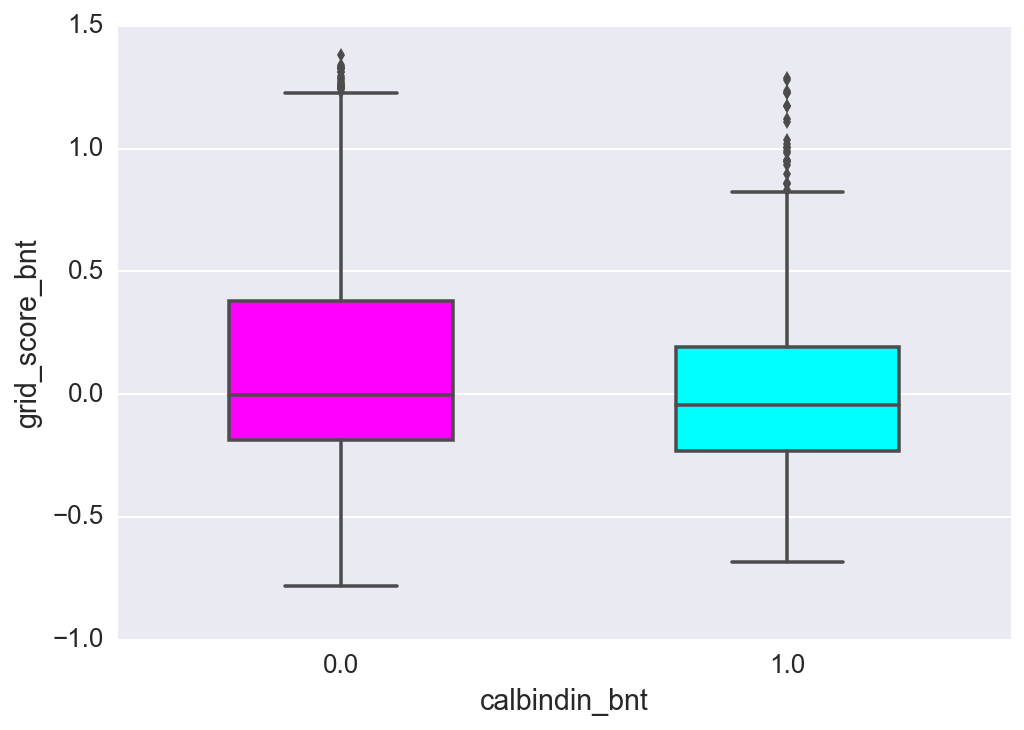

In [70]:
ax = sns.boxplot(x="calbindin_bnt", y="grid_score_bnt", data=base_dataframe2, width = 0.5)
# Select which box you want to change    
mybox = ax.artists[1]

# Change the appearance of that box
mybox.set_facecolor('cyan')


# Select which box you want to change    
mybox = ax.artists[0]

# Change the appearance of that box
mybox.set_facecolor('magenta')

#ax = sns.stripplot (x="calbindin_bnt", y="grid_score_bnt", data=base_dataframe2, color=".25", jitter=True)

In [ ]:
plot_comparisons_dave(only_grids, only_grids.grid_score_bnt, only_grids.calbindin_bnt)

<function matplotlib.pyplot.show>

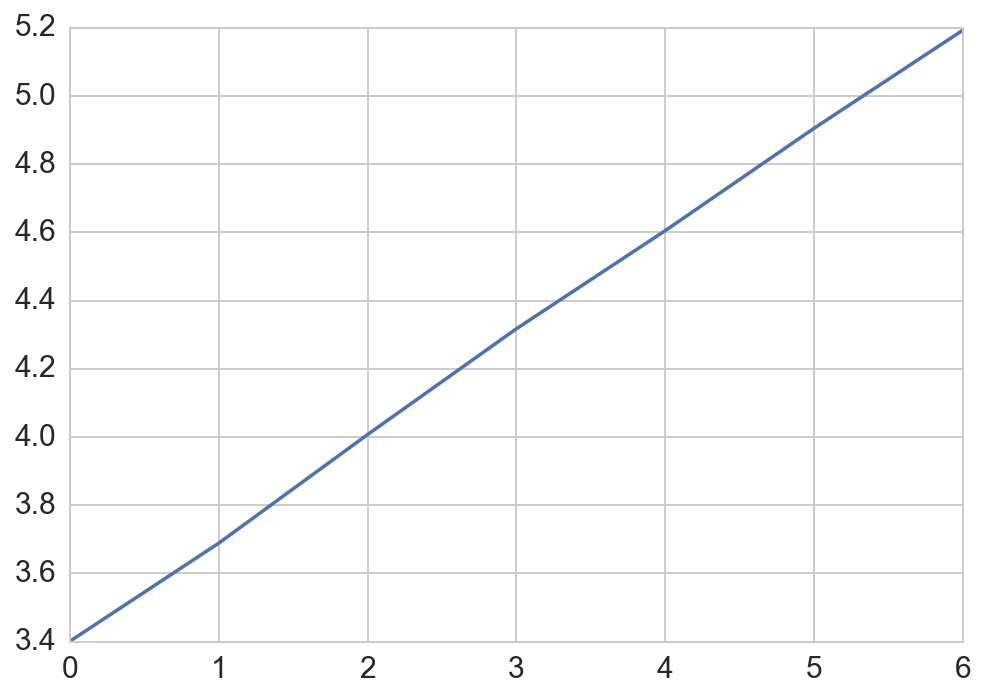

In [50]:
a = [30, 40, 55, 75, 100, 135, 180]
a = np.log(a)
plt.plot(a)
plt.show